In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import os
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp
import seaborn as sns
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient
from pathlib import Path
import h5py
from allen_v1dd.stimulus_analysis.natural_scenes import NaturalScenes
from matplotlib.colors import LinearSegmentedColormap
import itertools
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

In [20]:
## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

In [21]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

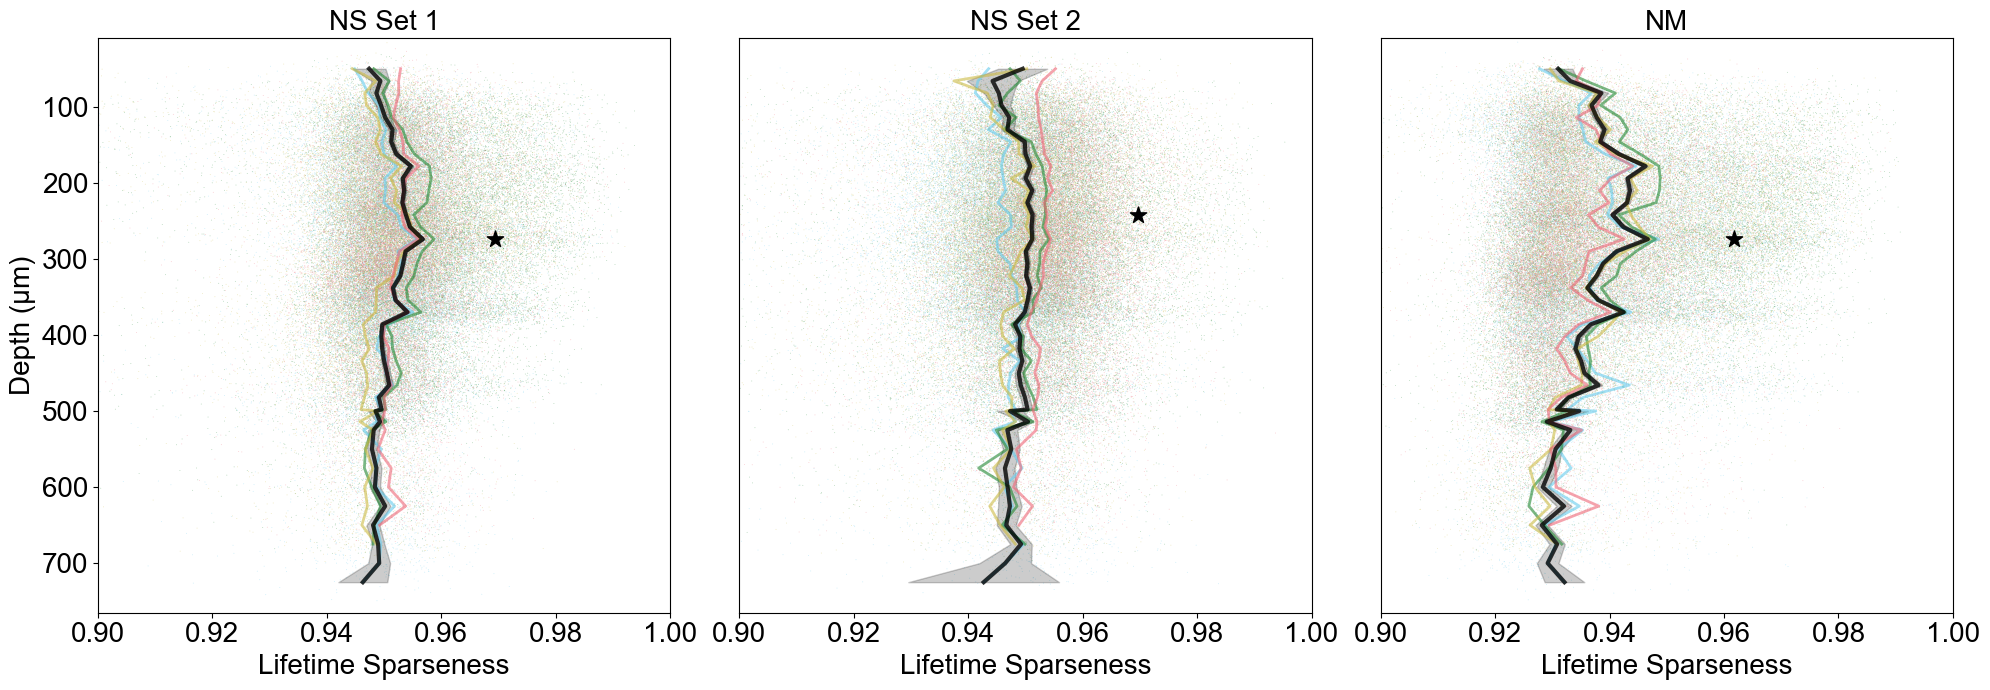

In [22]:
fontsize = 20
jitter_amount = 10
z_values = cell_info['z'].values

stim_list = ['ns118_ls', 'ns12_ls', 'nm_ls']
titles = ['NS Set 1', 'NS Set 2', 'NM']
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

fig, axs = plt.subplots(1, len(stim_list), figsize=(20, 7))
for idx, stim in enumerate(stim_list):
    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z',  
                 hue='mouse_id', 
                 estimator='mean',
                 palette=mouse_colors, 
                 linewidth=2, 
                 errorbar=None, 
                 alpha=0.6, 
                 orient='y', 
                 markers=True,
                 ax=axs[idx],
                 legend=False # if idx != 3 else True,
                 )
    # axs[idx].legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
    #     loc='upper right', bbox_to_anchor=(2, 1), fontsize=fontsize, title_fontsize=fontsize) if idx == 3 else None

    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z', 
                 color='black', 
                 estimator='mean',
                 err_style='band', 
                 errorbar=('se', 2), 
                 n_boot=1000, 
                 linewidth=3, 
                 alpha=0.8, 
                 orient='y', 
                 ax=axs[idx], 
                 legend=False)

    temp_df = cell_info.copy()
    temp_df['z'] = temp_df['z'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    if stim == 'dgf_pref_dir' or stim == 'dgw_pref_dir':
        temp_df[stim] = temp_df[stim] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x=stim,
                    y='z',
                    hue='mouse_id',
                    palette=mouse_colors,
                    s=0.4,
                    alpha=0.4,
                    ax=axs[idx],
                    legend=False,
                    zorder=0,
    )

    # Put asterisk next to the depth where the max median
    sub_df = cell_info.groupby('z')[stim].mean().reset_index()
    sub_array = sub_df[stim].values
    axs[idx].scatter(sub_array.max() + cell_info[stim].std(), sub_df.iloc[np.where(sub_array == sub_array.max())].z.values[0], 
            color='black', marker='*', s=150, edgecolor='black', zorder=1)

    axs[idx].set_xlabel('Lifetime Sparseness', fontsize=fontsize)
    axs[idx].set_title(titles[idx], fontsize=fontsize)
    axs[idx].set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else axs[idx].set_ylabel(" ")
    axs[idx].set_yticks([]) if idx != 0 else None
    axs[idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    # axs[idx].set_xlim(-0.05, 1.05) if idx < 4 else axs[idx].set_xlim(0.55, 0.95)
    axs[idx].set_xlim(0.9, 1)
    axs[idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[idx].invert_yaxis()

plt.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "figures", "SUPPFIG7A_ns_depth_plots.png"), format='png', dpi=300)

In [24]:
# -----------------------------
# Helper to convert p → stars
# -----------------------------
def p_to_stars(p):
    alpha_levels = [0.05, 0.01, 0.001, 0.0001]  # thresholds for *, **, ***, ****
    if np.isnan(p):
        return ""
    if p < alpha_levels[3]:
        return "****"
    elif p < alpha_levels[2]:
        return "***"
    elif p < alpha_levels[1]:
        return "**"
    elif p < alpha_levels[0]:
        return "*"
    return ""

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.957


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 242, mean accuracy = 0.951


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.947


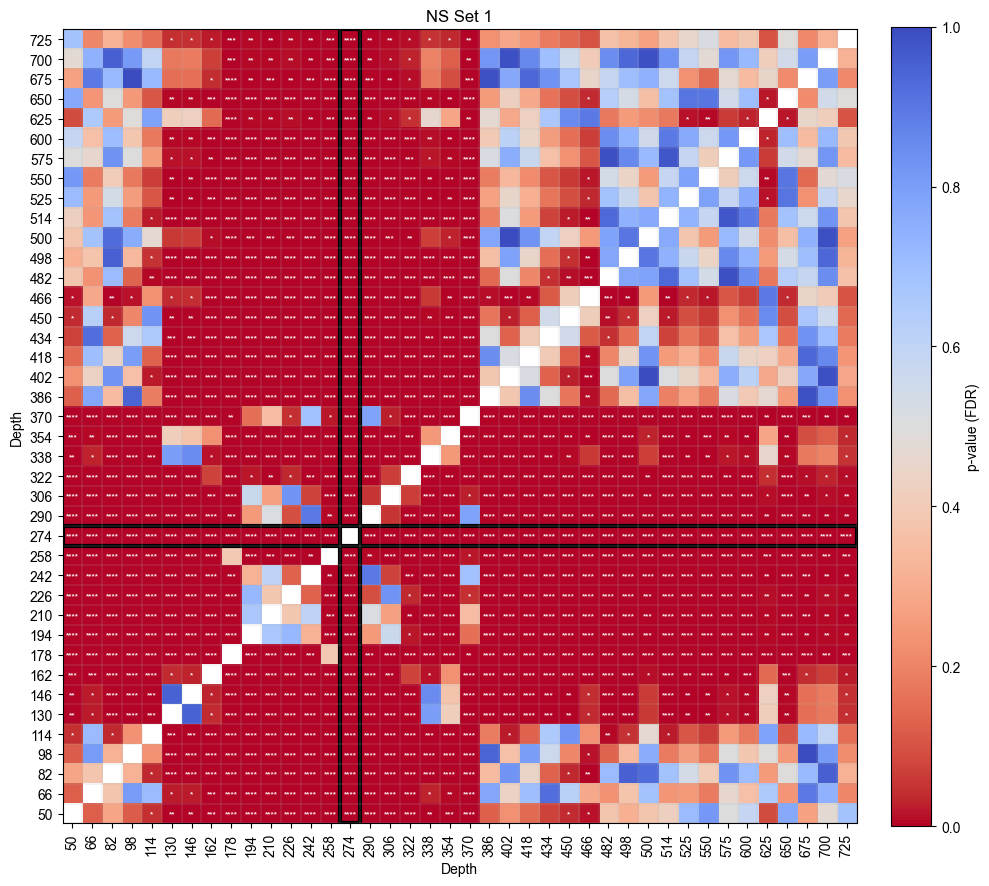

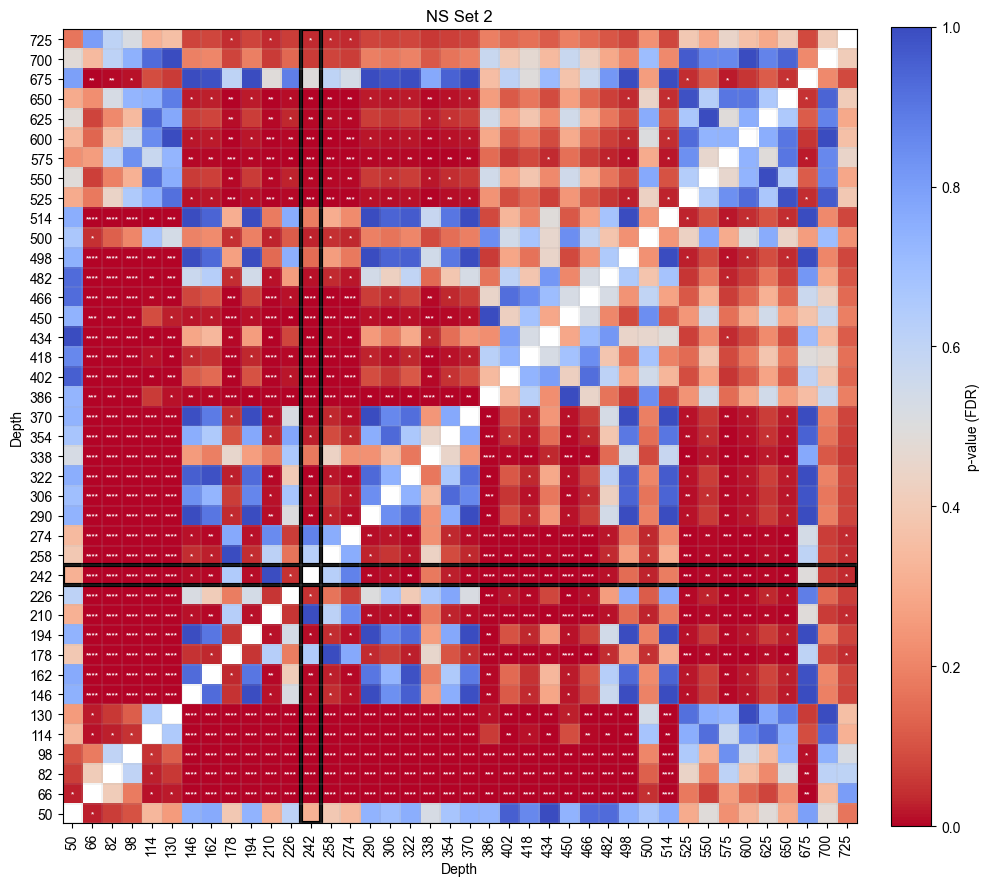

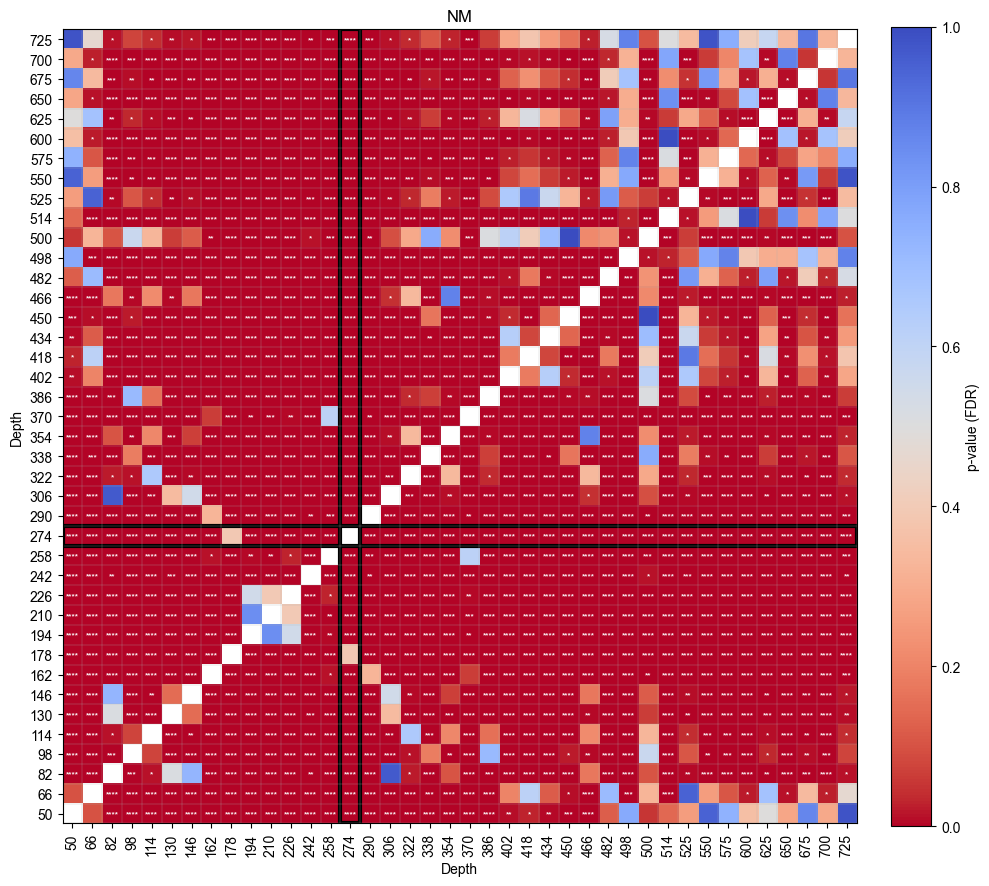

In [25]:
stim_list = ['ns118_ls', 'ns12_ls', 'nm_ls']
titles = ['NS Set 1', 'NS Set 2', 'NM']
# is_resp = True

for idx, stim_type in enumerate(stim_list):
    df = cell_info[['mouse_id', 'column', 'z', stim_type]]
    df = df.sort_values(by='z').reset_index(drop=True)
    df['mouse_id'] = df['mouse_id'].astype('category')
    df['column'] = df['column'].astype('category')
    df['z'] = df['z'].astype('category')
    depth_levels = df.z.unique()

    # 2) Fit the mixed model: accuracy ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        f"{stim_type} ~ C(z)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column": "0 + C(column)"}
    ).fit(method="lbfgs")

    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(z)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)

    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[idx]}") # - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)
    # ax.set_title("Pairwise depth comparisons (Mixed LME)\nHeat map of p-values with significance stars")

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("z")[stim_type].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG_sigtestsforsuppfig7a_{stim_type}.png"), format="png", dpi=300)

### Check the stimuli details for natural movie

The natural movie stimulus for the slc2 and TetO1 mice consisted of 3,600 frames (with 30 Hz frame rate) and was presented 8 times. For slc4 and slc5 mice, the natural movie stimulus consisted of 900 frames presented 30 times.


mice = ['slc2', 'slc4', 'slc5', 'teto1']

mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

slc2: 3600 frames x 8 times (total 29700)

slc4: 3600 frames x 9 times (total 29700)

slc5: 900 frames x 10 times (total 9000)

teto1: 900 frames x 30 times (total 27000)

In [ ]:
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()

mouse_id = 'M427836'  #slc5
col_vol_id = "11"
plane = 2
plane_name = f"Plane_{plane}"
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_id}")
stim_table_tuple = session.get_stimulus_table("natural_movie")
stim_table = stim_table_tuple[0]
len(stim_table)

9000